In this experiment we will use our DMRG optimiser to find the ground state
of an open-bounded transverse field Ising chain. The Hamiltonian reads:
$$
H = - \sum_{i=1}^{N-1} Z_i Z_{i+1} - h * \sum_{i=1}^{N} X_i.
$$
Here, the magnetic field is in the units of the nearest-neighbour ZZ-interaction.
We find the ground state of this Hamiltonian and compute some observables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from opt_einsum import contract
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

from ising import IsingExact, IsingMPO
from mdopt.mps.utils import create_simple_product_state
from mdopt.optimiser.dmrg import DMRG as dmrg

Let us first check we build the right MPO. We do this by virtue of constructing a 3-site MPO and then changing it into the Hamiltonian.

In [2]:
NUM_SITES = 3
H_MAGNETIC = 1.0
ising_exact = IsingExact(num_sites=NUM_SITES, h_magnetic=H_MAGNETIC)
ising_mpo = IsingMPO(num_sites=NUM_SITES, h_magnetic=H_MAGNETIC)
ham_mpo = ising_mpo.hamiltonian_mpo()
m = contract(
    "zabc, adef, dygh -> begcfh",
    ham_mpo[0],
    ham_mpo[1],
    ham_mpo[2],
    optimize=[(0, 1), (0, 1)],
).reshape((8, 8))

print(
    "Checking the exact and the MPO Hamiltonians being the same:",
    (ising_exact.hamiltonian_dense() == m).all(),
)

Checking the exact and the MPO Hamiltonians being the same: True


Then, we solve the model by both exact diagonalisation and DMRG. Afterwards, we need to check that the ground states are the same up to a phase.

In [3]:
NUM_SITES = 10
H_MAGNETIC = 1.0
NUM_DMRG_RUNS = 10
CHI_MAX = 128
CUT = 1e-12
MODE = "SA"
TOL = 1e-7
ising_exact = IsingExact(num_sites=NUM_SITES, h_magnetic=H_MAGNETIC)
ising_mpo = IsingMPO(num_sites=NUM_SITES, h_magnetic=H_MAGNETIC)
ham_mpo = ising_mpo.hamiltonian_mpo()
ham_sparse = ising_exact.hamiltonian_sparse()

mps_start = create_simple_product_state(NUM_SITES, which="+")

print("DMRG running:")
print("")
engine = dmrg(mps_start, ham_mpo, chi_max=CHI_MAX, cut=CUT, mode=MODE)
engine.run(NUM_DMRG_RUNS)
print("")
ground_state_mps = engine.mps
print("Eigensolver running.")
ground_state_exact = eigsh(ham_sparse, k=2, tol=TOL)[1][:, 0]
print(
    "The ground states are the same:",
    np.isclose(abs(ground_state_mps.dense()), abs(ground_state_exact)).all(),
)

DMRG running:



100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


Eigensolver running.
The ground states are the same: True


Now, we would like to compare the magnetisation plots from exact diagonalisation and DMRG. The plots should coincide exactly.

In [4]:
transverse_magnetic_field_space = np.linspace(0.2, 2.0, 20)
mag_z_exact = []
mag_x_exact = []
mag_z_dmrg = []
mag_x_dmrg = []
for magnetic_field in tqdm(transverse_magnetic_field_space):
    ising_exact = IsingExact(num_sites=NUM_SITES, h_magnetic=magnetic_field)
    ising_mpo = IsingMPO(num_sites=NUM_SITES, h_magnetic=magnetic_field)
    ham_mpo = ising_mpo.hamiltonian_mpo()
    ham_sparse = ising_exact.hamiltonian_sparse()
    mps_start = create_simple_product_state(num_sites=NUM_SITES, which="+")
    engine = dmrg(mps_start, ham_mpo, chi_max=CHI_MAX, cut=CUT, mode=MODE, silent=True)
    engine.run(NUM_DMRG_RUNS)
    ground_state_mps = engine.mps
    ground_state_exact = eigsh(ham_sparse, k=2, tol=TOL)[1][:, 0]

    mag_z_exact.append(ising_exact.average_chain_z_magnetisation(ground_state_exact))
    mag_x_exact.append(ising_exact.average_chain_x_magnetisation(ground_state_exact))

    mag_z_dmrg.append(ising_mpo.average_chain_z_magnetisation(ground_state_mps))
    mag_x_dmrg.append(ising_mpo.average_chain_x_magnetisation(ground_state_mps))

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Now we can take a look at the plots!

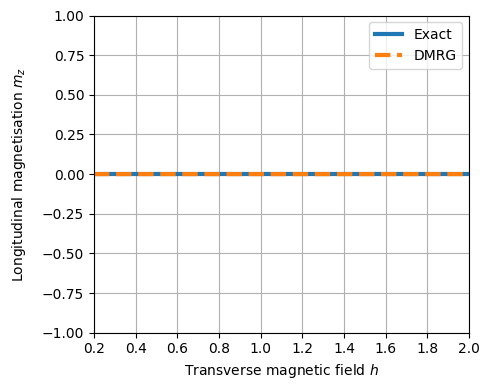

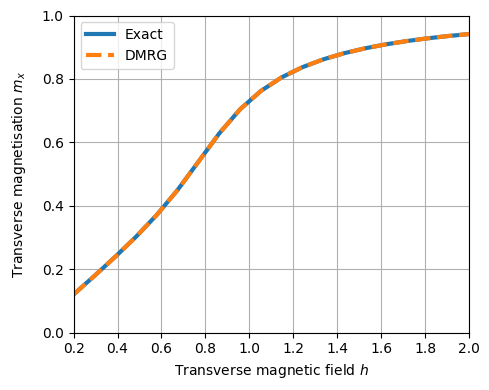

In [5]:
plt.figure(figsize=(5, 4))
plt.plot(transverse_magnetic_field_space, mag_z_exact, label="Exact", linewidth=3)
plt.plot(transverse_magnetic_field_space, mag_z_dmrg, label="DMRG", linestyle="dashed", linewidth=3)
plt.xlabel("Transverse magnetic field $h$")
plt.ylabel("Longitudinal magnetisation $m_z$", rotation=90, labelpad=10)
plt.xlim((0.2, 2))
plt.ylim((-1, 1))
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(transverse_magnetic_field_space, mag_x_exact, label="Exact", linewidth=3)
plt.plot(transverse_magnetic_field_space, mag_x_dmrg, label="DMRG", linestyle="dashed", linewidth=3)
plt.xlabel("Transverse magnetic field $h$")
plt.ylabel("Transverse magnetisation $m_x$", rotation=90, labelpad=10)
plt.xlim((0.2, 2))
plt.ylim((0, 1))
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()